In [ ]:
!pip install git+https://github.com/microsoft/dowhy.git
import dowhy
from dowhy import CausalModel

import numpy as np
import pandas as pd
import graphviz
import networkx as nx

np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

  Cloning https://github.com/microsoft/dowhy.git to /tmp/pip-req-build-t0tsm8g1
  Running command git clone --filter=blob:none --quiet https://github.com/microsoft/dowhy.git /tmp/pip-req-build-t0tsm8g1
  Resolved https://github.com/microsoft/dowhy.git to commit 9bfb39d44a82138feefeac1dc2cc89c56ca4ea7d
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
# Import data from Github

url="https://raw.githubusercontent.com/ReshmiMaulik/Understanding-Developer-Interaction/main/Data/workingdataO.csv"


#df = pd.read_csv(url, sep="\t", header= None)
df = pd.read_csv(url, sep=",")

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25531 entries, 0 to 25530
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ET      25531 non-null  float64
 1   CC      25531 non-null  int64  
 2   Pr      25531 non-null  int64  
 3   CI      25531 non-null  int64  
 4   OE      25531 non-null  int64  
 5   OW      25531 non-null  int64  
 6   NI      25531 non-null  int64  
 7   SI      25531 non-null  int64  
 8   RI      25531 non-null  int64  
 9   FI      25531 non-null  int64  
dtypes: float64(1), int64(9)
memory usage: 1.9 MB


In [ ]:
# Display the summary statistics in a pretty way
summary_stats = df.describe()
styled_summary_stats = summary_stats.style.format("{:.2f}").set_caption("Summary Statistics")
display(styled_summary_stats)


,ET,CC,Pr,CI,OE,OW,NI,SI,RI,FI
count,25531.00,25531.00,25531.00,25531.00,25531.00,25531.00,25531.00,25531.00,25531.00,25531.00
mean,1562.67,4.61,3.50,11.28,976.87,957.49,0.03,1.20,8.54,0.69
std,2191.51,2.08,1.55,15.69,3700.77,3569.57,1.01,4.30,13.59,2.68
min,0.00,3.00,1.00,2.00,0.00,1.00,0.00,0.00,0.00,0.00
25%,370.28,3.00,3.00,5.00,57.00,23.00,0.00,0.00,3.00,0.00
50%,859.55,4.00,4.00,8.00,242.00,67.00,0.00,0.00,6.00,0.00
75%,1757.49,5.00,5.00,12.00,1014.00,155.00,0.00,1.00,9.00,0.00
max,27426.68,30.00,6.00,616.00,57002.00,15804.00,153.00,175.00,435.00,120.00


In [ ]:
df

,ET,CC,Pr,CI,OE,OW,NI,SI,RI,FI
0,10.8953,3,1,2,309,56,3,0,0,0
1,142.3775,3,3,3,2242,181,1,0,0,2
2,24.7139,3,1,2,309,56,0,1,2,0
3,1786.8669,3,1,7,0,15804,1,0,0,2
4,1791.9464,4,4,9,367,67,0,1,2,3
...,...,...,...,...,...,...,...,...,...,...
25526,213.2314,4,5,5,27,1,0,2,4,0
25527,160.4950,3,5,3,425,78,0,0,3,0
25528,338.3767,3,1,5,113,22,0,0,3,0
25529,574.0781,5,6,6,139,19,0,2,8,0


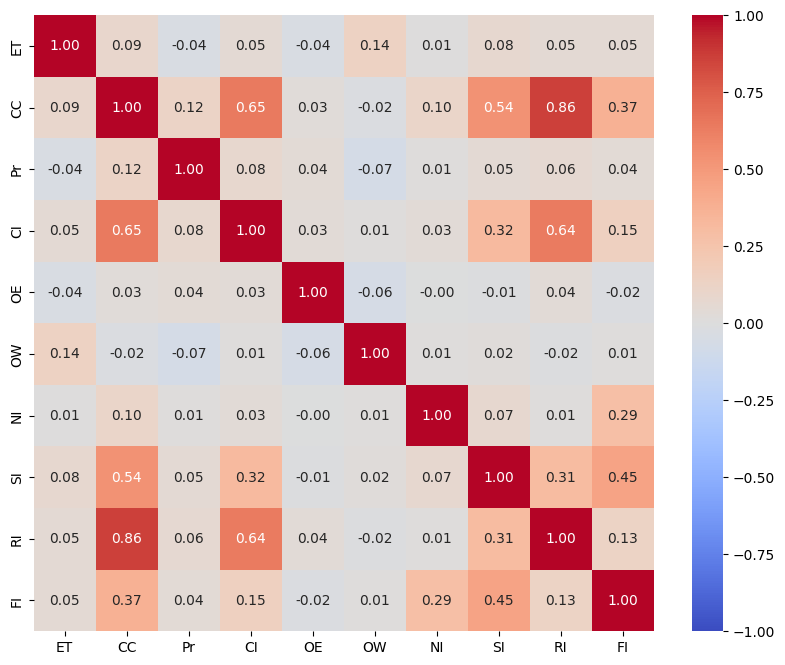

In [ ]:

import matplotlib.pyplot as plt

import seaborn as sns # Import seaborn library
corr = df.corr() # Calculates correlation matrix
# Create the heatmap
plt.figure(figsize=(10, 8))
ax = sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1)
#sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", vmin=-1, vmax=1, annot_kws={"size": number_cex})
#plt.title("Correlation Matrix")
plt.show()

Before we start calculating SHAP values we need to import our libraries, split our data and train a XGBoost model

In [ ]:
import xgboost
from sklearn.model_selection import train_test_split

In [ ]:
features = ['CC', 'Pr', 'CI', 'OE', 'OW', 'NI', 'SI', 'RI', 'FI']
X_train, X_test, y_train, y_test = train_test_split(df[features], df.ET, test_size=0.2)

In [ ]:
model = xgboost.XGBRegressor()
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

Generating Predictions

In [ ]:
y_predict = model.predict(X_test)

Evaluating Performance

In [ ]:
from sklearn.metrics import mean_squared_error
mean_squared_error(y_test, y_predict)**(0.5)

2100.2569602832054

**Global Interpretability with SHAP**
Summary Plot

In [ ]:
!pip install shap
import shap

shap.initjs()

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 3.6 MB/s eta 0:00:00


Display the summary_plot using SHAP values and testing set.

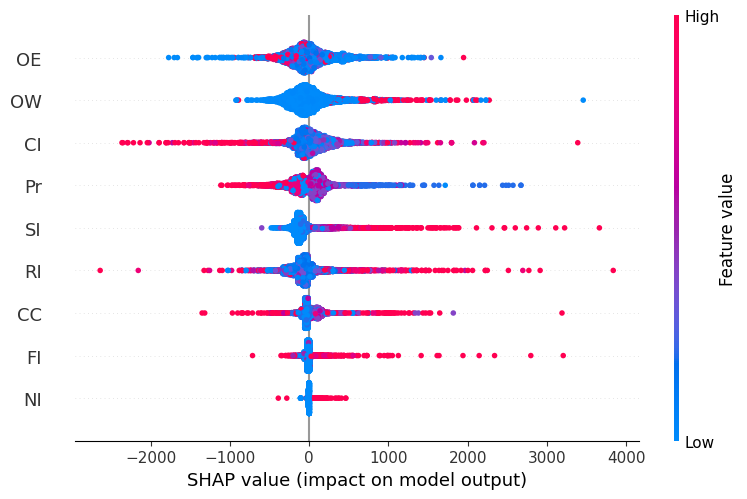

In [ ]:
import matplotlib.pyplot as plt


explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)
shap.summary_plot(shap_values, X_test)
#plt.savefig('SHAP_OpenStack.png')

**Beeswarm plots** are a more complex and information-rich display of SHAP values that reveal not just the relative importance of features, but their actual relationships with the predicted outcome.

Beeswarm plot, ranked by mean absolute SHAP value. This provides a rich overview of how the variables impact the model's predictions across all of the data.

If the value of a variable for a particular instance is relatively high, it appears as red dot. Relatively low variable values appear as blue dots.

We get the above plot by putting everything together under one roof. This shows the Shap values on the x-axis. Here, all the values on the left represent the observations that shift the predicted value in the negative direction while the points on the right contribute to shifting the prediction in a positive direction. All the features are on the left y-axis.

The summary plot shows the feature importance of each feature in the model. The results show that “OW,” “OE,”, "Pr" and “CC” play major roles in determining the results.

So here, high OW values are on the right side primarily because they contribute positively to the bug resolution for each bug. Similarly, for OE and Pr, they have a high impact on pushing the bug resolution in the negative direction.

Display the summary_plot using SHAP values and testing set.

**Dependence Plot**

One of the strengths of SHAP values is that they are based on the interaction between features. We can see the interactions between a feature and other features using a dependance plot. For instance, the dependance plot of OW and the feature with which it most strongly interacts, OE, can be seen below,

A dependence plot is a type of scatter plot that displays how a model's predictions are affected by a specific feature (Subscription Length). On average, subscription lengths have a mostly positive effect on the model.

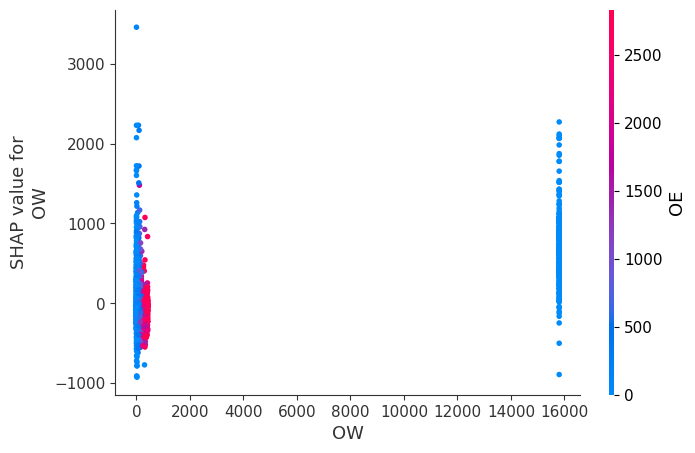

In [ ]:
shap.dependence_plot('OW', shap_values, X_test)

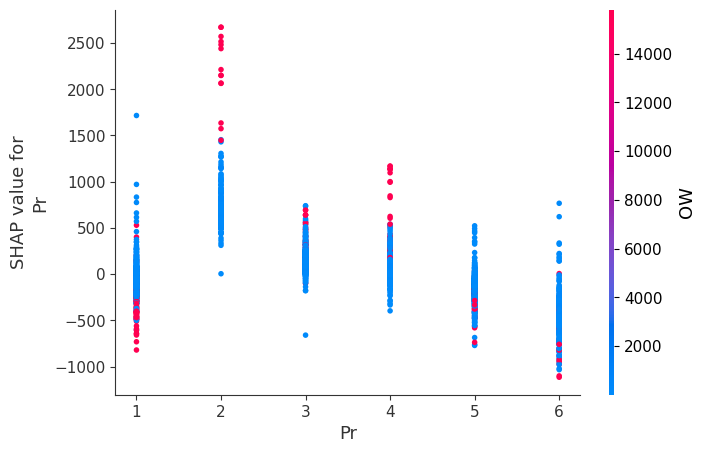

In [ ]:
shap.dependence_plot('Pr', shap_values, X_test)

Using dependance plots we can dig deeper into each features effect on the dataset. We can see a pretty strong trend of increasing SHAP value as the priority increases. We can also see from the color gradient that bugs with high ownerworkload and  priority < 4% generally have larger SHAP values than bugs with low ownerworkload. The opposite is generally true for bugs above 4% priority.

**Local Interpretability with SHAP**

Now we come to a something that really makes SHAP values standout. Local interpretability delves into explaining individual predictions made by the model, i.e. we can now see what is driving each prediction.

Using the same data, model, and SHAP explainer we can produce a Force Plot for each record. Before we plot the force plot we can make of SHAP values array into a Pandas Dataframe. This is convenient if you are wanting to see the SHAP values alongside features.

In [ ]:
# Need to load JS vis in the notebook
shap.initjs()

In [ ]:
shap_df = pd.DataFrame(shap_values, columns=features, index=X_test.index)
idx = 123
shap.force_plot(explainer.expected_value,
                shap_df.reset_index(drop=True).iloc[idx].values,
                X_test.reset_index(drop=True).iloc[idx])

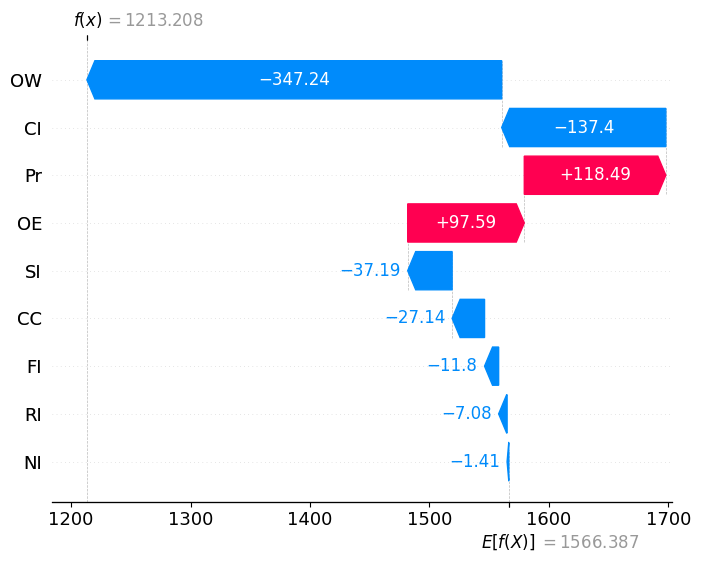

In [ ]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value,
                                       shap_df.reset_index(drop=True).iloc[idx].values,
                                       feature_names=X_test.columns)

SHAP values shown inside the red arrows correspond to the input variables that 'push' the model towards a higher bug resolution time whereas those in blue push the model towards a less bug resolution time. The final prediction function f(x) is equal to the base value plus the sum of all SHAP values.
The base value is the same for all examples in the data. It is equal to average of the bug resolution time in the dataset.

Using the waterfall or force plot we can see what features interacted the most to influence the prediction of the bug resolution time. We can see for the 123rd record in the test data that Pr decreased the predicted score by roughly -12966 from the base value, CC increased the predicted score by roughly 5651 from the base value, OE increased the predicted score by roughly 3506 from the base value, and CI  decreased the predicted score by roughly -2610 from the base value. Looking at how these features are distributed across the test we can start to see how the 123rd record is different.

SHAP values offer a dual perspective — global insights into feature importance and local explanations for individual predictions. By incorporating SHAP values into our machine learning workflow, we gain a deeper understanding of our models, ensure transparency, and unlock valuable insights from our data.

**Decision Plot**

We will now display the decision_plot. It visually depicts the model decisions by mapping the cumulative SHAP values for each prediction.

In [ ]:
shap.decision_plot(explainer.expected_value, shap_values, X_test.columns)

RuntimeError: Plotting 2650 observations may be slow. Consider subsampling or set ignore_warnings=True to ignore this message.

Application of SHAP Values

Apart from machine learning interpretability and explainability, SHAP value can be used for:

Model debugging. By examining the SHAP values, we can identify any biases or outliers in the data that may be causing the model to make mistakes.
Feature importance. Identifying and removing low-impact features can create a more optimized model.

Anchoring explanations. We can use SHAP values to explain individual predictions by highlighting the essential features that caused that prediction. It can help users understand and trust a model's decisions.

Model summaries. It can provide a global summary of a model in the form of a SHAP value summary plot. It gives an overview of the most important features across the entire dataset.

Detecting biases. The SHAP value analysis helps identify if certain features disproportionately affect particular groups. It enables the detection and reduction of discrimination in the model.
Fairness auditing. It can be used to assess a model's fairness and ethical implications.
Regulatory approval. SHAP values can help gain regulatory approval by explaining the model's decisions.

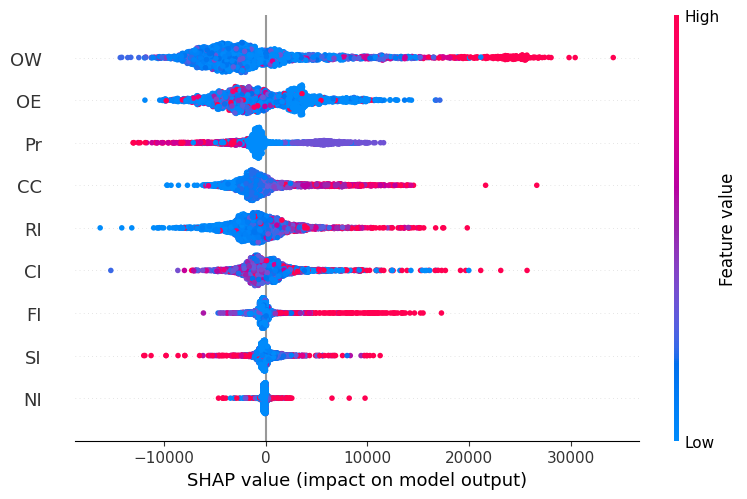

In [ ]:
# Assuming shap_values were calculated on X_test
shap.summary_plot(shap_values, features=X_test, feature_names=X_test.columns)

In [ ]:
#--new graph----Semi-Final code
causal_graphF = """strict digraph  {



NI->FI->CC->ET;
NI -> SI->CC->ET;
RI->CC->ET;
Pr->CI-> OE->ET;
Pr-> OW->ET;
OE->OW->ET;
CC->CI;
}

"""

In [ ]:
#--new graph----
causal_graph = """strict digraph  {

OW->RI;
RI->ET;
OW->ET;
OE->ET;
CI ->ET;
}

"""

In [ ]:
#--new graph----Final code
causal_graph = """strict digraph  {

OW->RI;
RI->ET;
OW->ET;
OE->ET;

}

"""

In [ ]:
!apt install libgraphviz-dev
!pip install pygraphviz

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libgail-common libgail18 libgtk2.0-0 libgtk2.0-bin libgtk2.0-common libgvc6-plugins-gtk
  librsvg2-common libxdot4
Suggested packages:
  gvfs
The following NEW packages will be installed:
  libgail-common libgail18 libgraphviz-dev libgtk2.0-0 libgtk2.0-bin libgtk2.0-common
  libgvc6-plugins-gtk librsvg2-common libxdot4
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 2,434 kB of archives.
After this operation, 7,681 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-common all 2.24.33-2ubuntu2.1 [125 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgtk2.0-0 amd64 2.24.33-2ubuntu2.1 [2,038 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libgail18 amd64 2.24.33-2ubuntu2.1 [15.9 kB]
Get:4 http://archive.ubun

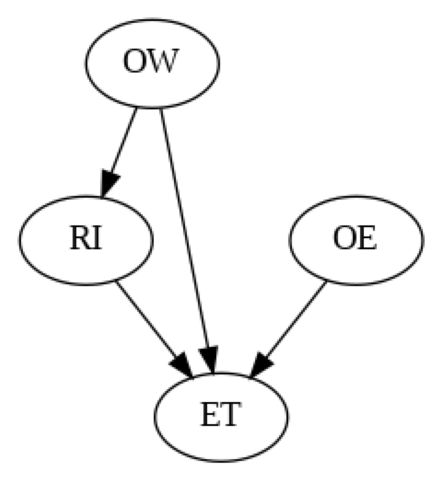

In [ ]:
from dowhy import CausalModel
from IPython.display import Image, display

model= CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='RI',       #ndev
        outcome='ET')

#model.view_model()
model.view_model(file_name="causal_model.png")

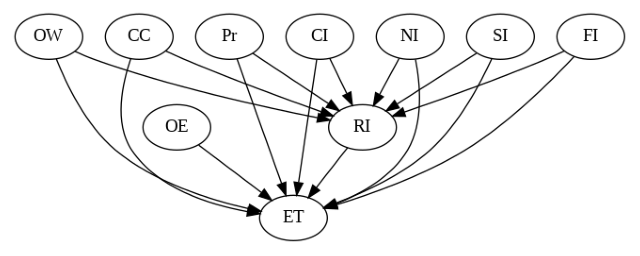

In [ ]:
# For Mediation analysis..Not required
from dowhy import CausalModel
from IPython.display import Image, display

model= CausalModel(
        data = df,
        graph=causal_graph.replace("\n", " "),
        treatment='RI',       #ndev
        outcome='ET',
        missing_nodes_as_confounders=True)

#model.view_model()
model.view_model(file_name="causal_model.png")

Identify the causal effect:

In [ ]:
estimands = model.identify_effect()
print(estimands)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[ET|OW])
d[RI]          
Estimand assumption 1, Unconfoundedness: If U→{RI} and U→ET then P(ET|RI,OW,U) = P(ET|RI,OW)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



Estimate

In [ ]:
estimate= model.estimate_effect(
 identified_estimand=estimands,
 method_name='backdoor.linear_regression',
 confidence_intervals=True,
  test_significance=True
)

print(f'Estimate of causal effect: {estimate}')

Streaming output truncated to the last 5000 lines.
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will a

Estimate of causal effect: *** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d            
─────(E[ET|OW])
d[RI]          
Estimand assumption 1, Unconfoundedness: If U→{RI} and U→ET then P(ET|RI,OW,U) = P(ET|RI,OW)

## Realized estimand
b: ET~RI+OW+RI*OE
Target units: 

## Estimate
Mean value: 9.025651559477865
p-value: [0.]
95.0% confidence interval: (6.211215962817732, 11.234819739016075)
### Conditional Estimates
__categorical__OE
(-0.001, 39.0]       9.636368
(39.0, 139.0]        9.592247
(139.0, 399.0]       9.478583
(399.0, 1396.0]      9.148191
(1396.0, 57002.0]    7.233890
dtype: float64


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

 Conditional Estimates
__categorical__OE
(-0.001, 39.0]       9.636368
(39.0, 139.0]        9.592247
(139.0, 399.0]       9.478583
(399.0, 1396.0]      9.148191
(1396.0, 57002.0]    7.233890

Refutation

Refuting the estimate

In [ ]:
refutel_common_cause=model.refute_estimate(estimands,estimate,"random_common_cause")
print(refutel_common_cause)

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

Refute: Add a random common cause
Estimated effect:9.025651559477865
New effect:9.02458758720755
p value:0.86



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

Refute: Add a random common cause
Estimated effect:9.025651559477865
New effect:9.025893347968985
p value:0.98

Final:  Refute: Add a random common cause
Estimated effect:9.025651559477865
New effect:9.02458758720755
p value:0.86

Removing a random subset of the data

In [ ]:
refutel_common_cause=model.refute_estimate(estimands,estimate,"data_subset_refuter")
print(refutel_common_cause)

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

Refute: Use a subset of data
Estimated effect:9.025651559477865
New effect:9.065842742424303
p value:1.0



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFra

Refute: Use a subset of data
Estimated effect:9.025651559477865
New effect:8.90466268310124
p value:0.84

Final->Refute: Use a subset of data
Estimated effect:9.025651559477865
New effect:9.065842742424303
p value:1.0

Replacing treatment with a random (placebo) variable

In [ ]:
refutation = model.refute_estimate(estimands, estimate, method_name="placebo_treatment_refuter", placebo_type="permute", num_simulations=100)
print(refutation)


/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

Refute: Use a Placebo Treatment
Estimated effect:9.025651559477865
New effect:-0.04398494981694512
p value:0.92



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adop

Refute: Use a Placebo Treatment
Estimated effect:9.025651559477865
New effect:-0.08778022345330783
p value:0.84


Final-> Placebo treatment Estimated effect:9.025651559477865
New effect:-0.04398494981694512
p value:0.92

In [ ]:
es_random=model.refute_estimate(estimands,estimate, method_name="random_common_cause", show_progress_bar= True)

Refuting Estimates:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

In [ ]:
print(es_random)

Refute: Add a random common cause
Estimated effect:9.025651559477865
New effect:9.025354124141309
p value:0.98



In [ ]:
#Add an Unobserved Common Cause
res_unobserved=model.refute_estimate(estimands, estimate, method_name="add_unobserved_common_cause",
                                     confounders_effect_on_treatment="binary_flip", confounders_effect_on_outcome="linear",
                                    effect_strength_on_treatment=0.01, effect_strength_on_outcome=0.02)
print(res_unobserved)

Refute: Add an Unobserved Common Cause
Estimated effect:9.025651559477865
New effect:8.689475373838377



/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimator.py:266: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  by_effect_mods = data.groupby(effect_modifier_names)
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/usr/local/lib/python3.10/dist-packages/dowhy/causal_estimators/regression_estimator.py:131: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behav

**Step 2: Identifying the natural direct and indirect effects**

We use the estimand_type argument to specify that the target estimand should be for a natural direct effect or the natural indirect effect. For definitions, see Interpretation and Identification of Causal Mediation by Judea Pearl.

Natural direct effect: Effect due to the path OW->ET

Natural indirect effect: Effect due to the path OW->RI->ET (mediated by RI).

In [ ]:
# Natural direct effect (nde)
identified_estimand_nde = model.identify_effect(estimand_type="nonparametric-nde",
                                            proceed_when_unidentifiable=True)
print(identified_estimand_nde)

Estimand type: EstimandType.NONPARAMETRIC_NDE

### Estimand : 1
Estimand name: mediation
No such variable(s) found!



In [ ]:
# Natural indirect effect (nie)
identified_estimand_nie = model.identify_effect(estimand_type="nonparametric-nie",
                                            proceed_when_unidentifiable=True)
print(identified_estimand_nie)

Estimand type: EstimandType.NONPARAMETRIC_NIE

### Estimand : 1
Estimand name: mediation
No such variable(s) found!



Step 3: Estimation of the effect
Natural Indirect Effect **bold text**

In [ ]:
import dowhy.causal_estimators.linear_regression_estimator
causal_estimate_nie = model.estimate_effect(identified_estimand_nie,
                                        method_name="mediation.two_stage_regression",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                            'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                        }
                                       )
print(causal_estimate_nie)

ERROR:dowhy.causal_estimator:No valid identified estimand available.


Estimation failed! No relevant identified estimand available for this estimation method.


Natural Direct Effect

In [ ]:
causal_estimate_nde = model.estimate_effect(identified_estimand_nde,
                                        method_name="mediation.two_stage_regression",
                                       confidence_intervals=False,
                                       test_significance=False,
                                        method_params = {
                                            'first_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator,
                                            'second_stage_model': dowhy.causal_estimators.linear_regression_estimator.LinearRegressionEstimator
                                        }
                                       )
print(causal_estimate_nde)

ERROR:dowhy.causal_estimator:No valid identified estimand available.


Estimation failed! No relevant identified estimand available for this estimation method.


https://www.kaggle.com/code/carlmcbrideellis/causal-forests-double-ml-example-using-econml

https://github.com/py-why/EconML

https://econml.azurewebsites.net/

In [ ]:
!pip install forestplot
import pandas as pd
import forestplot as fp

# Sample data
#data = pd.DataFrame({
 #   "exposure": ["SNP1", "SNP2", "SNP3"],
  #  "outcome": ["Disease A", "Disease A", "Disease A"],
   # "effect": [1.2, 0.8, 1.05],
    #"lower_ci": [1.0, 0.6, 0.9],
   # "upper_ci": [1.4, 1.0, 1.2],
   # "pval": [0.05, 0.1, 0.5]
#})

# Create forest plot
ax = fp.forestplot(data,
                   estimate="effect",
                   lower="lower_ci",
                   upper="upper_ci",
                   label="exposure",
                   pvalues="pval",
                   xticks=[0.5, 1, 1.5],
                   lineheight="auto",
                   figsize=(8, 6))

# Add title and labels
ax.set_title("MR Analysis Results")
ax.set_xlabel("Effect Size")
ax.set_ylabel("SNP")

# Show the plot
plt.show()

https://nbviewer.org/github/LSYS/forestplot/blob/mplot-dev/examples/test-multmodel-sleep.ipynb

In [ ]:
!pip install forestplot
import sys
sys.path.append('../')
import pandas as pd
import numpy as np
import forestplot as fp
pd.set_option('display.max_rows', 100)

url="https://raw.githubusercontent.com/ReshmiMaulik/Understanding-Developer-Interaction/main/Data/workingdataO.csv"

df = pd.read_csv(url, sep=",").query("ET=='9.02565' | OW=='1000'")
df.head(3)

#df = (pd.read_csv('../examples/data/sleep-mmodel.csv')
 #     .query("model=='all' | model=='young kids'")
 #    )
#df.head(3)

,ET,CC,Pr,CI,OE,OW,NI,SI,RI,FI


In [ ]:
std_opts = dict(
    dataframe = df,
    estimate = "ET",
    ll  ="OE",
    hl = "NI",
    varlabel = "RI",
    model_col = "OW",
    return_df=True,
)

In [ ]:
# Cusal forest

!pip install econml
from econml.dml import CausalForestDML
from sklearn.linear_model import LassoCV
# Use defaults
est = CausalForestDML()
# Or specify hyperparameters
est = CausalForestDML(criterion='het', n_estimators=500,
                      min_samples_leaf=10,
                      max_depth=10, max_samples=0.5,
                      discrete_treatment=False,
                      model_t=LassoCV(), model_y=LassoCV())
est.fit(Y, T, X=X, W=W)
treatment_effects = est.effect(X_test)
# Confidence intervals via Bootstrap-of-Little-Bags for forests
lb, ub = est.effect_interval(X_test, alpha=0.05)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 39.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 532.9/532.9 kB 31.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 237.3/237.3 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: slicer
    Found existing installation: slicer 0.0.8
    Uninstalling slicer-0.0.8:
      Successfully uninstalled slicer-0.0.8
  Attempting uninstall: shap
    Found existing installation: shap 0.46.0
    Uninstalling shap-0.46.0:
      Successfully uninstalled shap-0.46.0


NameError: name 'Y' is not defined

https://www.kaggle.com/code/carlmcbrideellis/causal-forests-double-ml-example-using-econml

In the synthetic data

Y is the target
T is the feature of interest
X are the control vectors ∼U(0,1)

W is a matrix of the confounders ∼N(0,1)

https://www.sciencedirect.com/science/article/pii/S2352711022002126

Causal ML: Python package for causal inference machine learning

In [ ]:
import numpy as np
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from econml.dml import CausalForestDML
from skinlearn.ensemble import RandomForestRegressor # Make sure to import RandomForestRegressor


# Dummy data generation
X, y = make_regression(n_samples=1000, n_features=5, n_informative=3, random_state=42)
treatment = np.random.binomial(1, 0.5, size=1000) # Generate random treatment assignment
y = y + 2.0 * treatment  # Add treatment effect manually

# Data Division
X_train, X_test, y_train, y_test, treat_train, treat_test = train_test_split(X, y, treatment, test_size=0.2, random_state=42)

# Causal Forest Model Building and Learning
causal_forest = CausalForestDML(model_y=RandomForestRegressor(), model_t=RandomForestRegressor())
causal_forest.fit(Y=y_train, T=treat_train, X=X_train)

# Indication of estimated causal effects
effect = causal_forest.effect(X_test)
print("Causal effect:", effect)

ModuleNotFoundError: No module named 'econml'

In the above code, the make_regression function is used to generate dummy data, where Y is the objective variable, T is the intervention variable (treatment), and X is the feature. The Causal Forest model is then constructed using the CausalForestDML class, and the fit method is used to train the model on the data. model_y and model_t are the models used to estimate causal effects. In the above example, RandomForestRegressor is used to perform the regression task, but an appropriate model should be selected. Finally, the effect method is used to estimate the causal effects of the test data.

https://github.com/py-why/dowhy

https://www.pywhy.org/dowhy/v0.11.1/getting_started/index.html

https://www.pywhy.org/dowhy/v0.11.1/example_notebooks/dowhy-conditional-treatment-effects.html

Forest Plot

In [ ]:
import pandas as pd

url="https://raw.githubusercontent.com/ReshmiMaulik/Understanding-Developer-Interaction/main/Data/workingdataO.csv"

df = pd.read_csv(url,header=None)

#df = fp.load_data(url)  # companion example data
df.head(5)

,0,1,2,3,4,5,6,7,8,9
0,ET,CC,Pr,CI,OE,OW,NI,SI,RI,FI
1,10.8953,3,1,2,309,56,3,0,0,0
2,142.3775,3,3,3,2242,181,1,0,0,2
3,24.7139,3,1,2,309,56,0,1,2,0
4,1786.8669,3,1,7,0,15804,1,0,0,2


In [ ]:
import pandas as pd
from sklearn.preprocessing import StandardScaler

url = "https://raw.githubusercontent.com/ReshmiMaulik/Understanding-Developer-Interaction/main/Data/workingdataO.csv"
df = pd.read_csv(url, header=None)

# Convert all columns to numeric, errors='coerce' will replace non-numeric values with NaN
df = df.apply(pd.to_numeric, errors='coerce')

# Select only numerical columns for scaling (ignoring columns with all NaN values)
numerical_cols = df.select_dtypes(include=['number']).columns[df.select_dtypes(include=['number']).any()]  # Added any() condition
df_numerical = df[numerical_cols]

# Apply StandardScaler to numerical columns only
ss = StandardScaler()
df_scaled_numerical = ss.fit_transform(df_numerical)

# Create a new DataFrame with scaled numerical features
df_scaled = pd.DataFrame(df_scaled_numerical, columns=numerical_cols, index=df.index)

# Concatenate scaled numerical features with original non-numerical features
non_numerical_cols = df.select_dtypes(exclude=['number']).columns
df_scaled = pd.concat([df_scaled, df[non_numerical_cols]], axis=1)

# Print the scaled DataFrame
print(df_scaled.head())

          0        1         2         3         4         5         6  \
0       NaN      NaN       NaN       NaN       NaN       NaN       NaN   
1 -0.708098 -0.77453 -1.615259 -0.591674 -0.180470 -0.252552  2.942962   
2 -0.648101 -0.77453 -0.323467 -0.527932  0.341864 -0.217533  0.958760   
3 -0.701792 -0.77453 -1.615259 -0.591674 -0.180470 -0.252552 -0.033341   
4  0.102304 -0.77453 -1.615259 -0.272963 -0.263968  4.159271  0.958760   

          7         8         9  
0       NaN       NaN       NaN  
1 -0.280053 -0.627933 -0.256734  
2 -0.280053 -0.627933  0.488243  
3 -0.047554 -0.480816 -0.256734  
4 -0.280053 -0.627933  0.488243  


In [ ]:
!pip install forestplot
import forestplot as fp

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(df_scaled[features], df_scaled.ET, test_size=0.2)

KeyError: "None of [Index(['CC', 'OE', 'OW', 'NI', 'SI', 'RI'], dtype='object')] are in the [columns]"

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split

url="https://raw.githubusercontent.com/ReshmiMaulik/Understanding-Developer-Interaction/main/Data/workingdataO.csv"

# Assuming the first row of the CSV contains the column names,
# set header=0 to use the first row as headers
df = pd.read_csv(url, header=0)

#features = ['CC', 'Pr', 'CI', 'OE', 'OW', 'NI', 'SI', 'RI', 'FI']
features = ['CC', 'OE', 'OW', 'NI', 'SI', 'RI']

# Now, df[features] should correctly select the desired columns
X_train, X_test, y_train, y_test = train_test_split(df[features], df.ET, test_size=0.2)



NameError: name 'df_scaled' is not defined

In [ ]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

# Ensure y_train is within the [0, 1] interval
y_train = np.clip(y_train, 0, 1)  # Clip values to be between 0 and 1

# 1. Check for and remove highly correlated features:
# Calculate the correlation matrix
corr_matrix = X_train.corr()

# Set a threshold for correlation (e.g., 0.9)
threshold = 0.9

# Identify highly correlated features
highly_correlated = np.where(np.abs(corr_matrix) > threshold)
highly_correlated = [(corr_matrix.index[x[0]], corr_matrix.columns[x[1]]) for x in zip(*highly_correlated) if x[0] != x[1]]

# Remove one of the highly correlated features from X_train
# Choose which feature to remove based on domain knowledge or other criteria
features_to_remove = [feature[1] for feature in highly_correlated]  # Example: remove the second feature in each correlated pair
X_train = X_train.drop(columns=features_to_remove)


# 2. Add a small amount of regularization:
# This can help stabilize the model and prevent singularity
# Create a Logit model with regularization
model = sm.Logit(y_train, X_train)
# Add regularization (e.g., L2 regularization)
# Adjust the regularization strength (alpha) as needed
# Other methods like 'bfgs' or 'lbfgs' can also be used here
model_fit = model.fit_regularized(alpha=0.01, method='l1')

# 3.  Consider dimensionality reduction techniques:
# If you have a large number of features, consider using techniques like PCA to reduce dimensionality
# and potentially remove multicollinearity.
# from sklearn.decomposition import PCA
# pca = PCA(n_components=0.95)  # Keep components explaining 95% of variance
# X_train = pca.fit_transform(X_train)

Iteration limit reached    (Exit mode 9)
            Current function value: 0.2716794432467245
            Iterations: 1000
            Function evaluations: 10781
            Gradient evaluations: 1000


In [ ]:
# ... (your existing code) ...

# Create a Logit model with regularization
model = sm.Logit(y_train, X_train)
# Add regularization (e.g., L2 regularization)
# Adjust the regularization strength (alpha) as needed
# Other methods like 'bfgs' or 'lbfgs' can also be used here
model_fit = model.fit_regularized(alpha=0.01, method='l1')

# Print the summary of the FITTED model
print(model_fit.summary()) # Changed from model.summary() to model_fit.summary()

Iteration limit reached    (Exit mode 9)
            Current function value: 0.2716794432467245
            Iterations: 1000
            Function evaluations: 10781
            Gradient evaluations: 1000
                           Logit Regression Results                           
Dep. Variable:                     ET   No. Observations:                20424
Model:                          Logit   Df Residuals:                    20420
Method:                           MLE   Df Model:                            3
Date:                Wed, 06 Nov 2024   Pseudo R-squ.:                  -17.78
Time:                        07:18:51   Log-Likelihood:                -5548.7
converged:                      False   LL-Null:                       -295.40
Covariance Type:            nonrobust   LLR p-value:                     1.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
OE    

In [ ]:
#import numpy as np
params = model_fit.params # Use model_fit instead of model
conf = model_fit.conf_int() # Use model_fit instead of model
conf['Odds Ratio'] = params
conf.columns = ['2.5%', '97.5%', 'Odds Ratio']# convert log odds to ORs
odds = pd.DataFrame(np.exp(conf))# check if pvalues are significant
odds['pvalues'] = model_fit.pvalues # Use model_fit instead of model
odds['significant?'] = ['significant' if pval <= 0.05 else 'not significant' for pval in model_fit.pvalues] # Use model_fit instead of model
odds

,2.5%,97.5%,Odds Ratio,pvalues,significant?
OE,1.000293,1.000538,1.000416,2.774587e-11,significant
OW,1.012214,1.014413,1.013313,4.029343e-126,significant
NI,1.721196,4.095085,2.654891,1.006600e-05,significant
SI,19.160114,31.036530,24.385723,1.492044e-148,significant


 In general, an OR value > 1 indicates increase of bug resolution time, while an OR value < 1 indicates reducedion in bug resolution time.

In [ ]:
# prompt: Using dataframe odds: Forest Plot

import altair as alt
# Rename columns for better plot aesthetics
odds = odds.rename(columns={'2.5%': 'Lower CI', '97.5%': 'Upper CI', 'Odds Ratio': 'OR'})

# Create the forest plot
alt.Chart(odds).mark_point(
    filled=True,
    size=100
).encode(
    x=alt.X('OR', title='Odds Ratio'),
    y=alt.Y('pvalues', title='p-values'),
    color=alt.Color('significant?', title='Significance'),
    tooltip=['pvalues', 'OR', 'Lower CI', 'Upper CI']
).properties(width=600, height=400)




alt.Chart(...)

To visualize the logistic regression results, I used a forest plot (or blobbogram). Specifically, the forest plot was used to graphically represent the odds ratios and their corresponding confidence intervals. The markers reflect the odds ratios while the whiskers represent the confidence limits. I used the matplotlib library to generate this plot in Python. We can see that by representing the results with a forest plot, the story of our analysis is now much clearer.

We can further enhance the figure above by including information on the statistical significance of the variable. Thus, I used color to distinguish statistically significant variables (red-colored lines) from those that are not statistically significant (gray-colored lines).

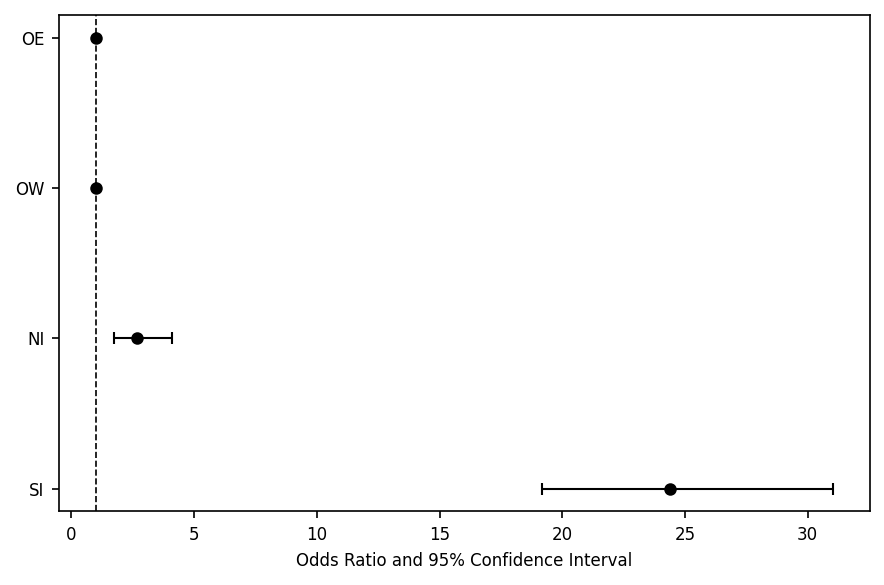

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6, 4), dpi=150)
# Use the new column name 'OR' instead of 'Odds Ratio'
ci = [odds.iloc[::-1]['OR'] - odds.iloc[::-1]['Lower CI'].values, odds.iloc[::-1]['Upper CI'].values - odds.iloc[::-1]['OR']]
plt.errorbar(x=odds.iloc[::-1]['OR'], y=odds.iloc[::-1].index.values, xerr=ci,
            color='black',  capsize=3, linestyle='None', linewidth=1,
            marker="o", markersize=5, mfc="black", mec="black")
plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
# plt.savefig('raw_forest_plot.png')
plt.show()

Forest plots showing the causal associations between Bug resolution time and the features('CC', 'OE', 'OW', 'NI', 'SI', 'RI').

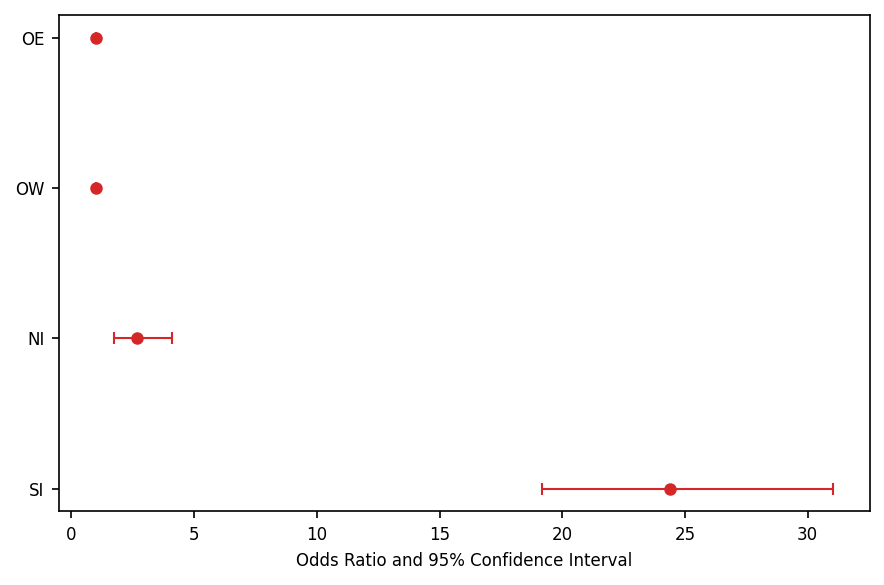

In [ ]:
fig, ax = plt.subplots(nrows=1, sharex=True, sharey=True, figsize=(6, 4), dpi=150)
for idx, row in odds.iloc[::-1].iterrows():
    # Use the new column names 'Lower CI', 'Upper CI', and 'OR'
    ci = [[row['OR'] - row['Lower CI']], [row['Upper CI'] - row['OR']]]  # Changed this line
    if row['significant?'] == 'significant':
        plt.errorbar(x=[row['OR']], y=[row.name], xerr=ci,
            ecolor='tab:red', capsize=3, linestyle='None', linewidth=1, marker="o",
                     markersize=5, mfc="tab:red", mec="tab:red")
    else:
        plt.errorbar(x=[row['OR']], y=[row.name], xerr=ci,
            ecolor='tab:gray', capsize=3, linestyle='None', linewidth=1, marker="o",
                     markersize=5, mfc="tab:gray", mec="tab:gray")
        plt.axvline(x=1, linewidth=0.8, linestyle='--', color='black')
plt.tick_params(axis='both', which='major', labelsize=8)
plt.xlabel('Odds Ratio and 95% Confidence Interval', fontsize=8)
plt.tight_layout()
plt.savefig('forest_plot.png')
plt.show()

circle (red): effect size of the indvidual studies. In this example, the effect size is represented by the standardised mean difference between the averages of the two groups. Other possible effect sizes are mean difference, odds ratio, or hazard ratio.

Horizontal (red) lines: 95% confidence intervals (CI). The interpretation is that we are 95% confident that the true value of the effect size lies between the lower and upper bounds. The wider the CI the less precise the study.
    Dotted Line: this line is known as line of no effect and it is plotted at the exact point where, relative to the effect size chosen in the analyis, there is no difference between the estimates of the two groups. If the effect size is based on a difference, the line of no effect will be at 0, whereas if the effect size is based on a ratio, the line of no effect will be at 1. This line is very useful to interpret the results, in fact, if the CI intersects the line, the results are NOT significant. In this case the pooled summary effect is not significant.
    Weight: study weight is proportional to study precision and it represents the influence of each individual study on the pooled effect size. More practically, when the standard error of the estimate of a study increases, its weight decreases. An alternative approach is to use a weight that is positively correlated with sample size.
    SMD (95% CI): summary of effect size and confidence intervals in the graphical representation.



SEM in Python

In [ ]:
!pip install semopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 15.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 2.6 MB/s eta 0:00:00
  Created wheel for semopy: filename=semopy-2.3.11-py3-none-any.whl size=1659681 sha256=41ee8cb80149e6b725ac3e4c0ad81864876bc5a06593bf8a53b3059caf6665b6
  Stored in directory: /root/.cache/pip/wheels/53/ec/0d/0b294c02d8c4e9e80afea58839f2c1b4706770594bc99ec045
Successfully built semopy


In [ ]:
import semopy as sem
import pandas as pd
import numpy as np

In [ ]:
#Mediation analysis

specmodel= """
# measurement model
# Direct Effect
ET ~ c * OW
RI ~ a * OW
ET ~ b * RI
"""
# Label the effects
#direct := c
# indirect effect
#indirect := a* b
# total := direct + indirect
#prop_mediated := indirect/total



In [ ]:
import semopy
# Define the model
model = semopy.Model(specmodel)
#Fit the model

model.fit(df)
# Inspect the results
print(model.inspect())

  lval  op rval      Estimate      Std. Err     z-value   p-value
0   RI   ~   OW -5.717007e-05      0.000024   -2.409268  0.015985
1   ET   ~   OW  8.580920e-02      0.002717   31.579488  0.000000
2   ET   ~   RI  1.129347e+01      0.716575   15.760340  0.000000
3   RI  ~~   RI  1.831680e+02      1.621178  112.984512  0.000000
4   ET  ~~   ET  2.401271e+06  21253.097955  112.984512  0.000000


In [ ]:
!brew install graphviz

/bin/bash: line 1: brew: command not found


In [ ]:
import matplotlib.pyplot as plt # Import the matplotlib.pyplot module

SEM Model diagram saved as 'openstack_sem_model.png'.


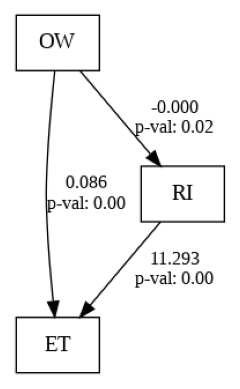

In [ ]:
semopy.semplot(model, 'openstack_sem_model.png')
print("SEM Model diagram saved as 'openstack_sem_model.png'.")
img = plt.imread('openstack_sem_model.png')
plt.imshow(img)
plt.axis('off')
plt.show()

In [ ]:
model.fit(df, obj="MLW", solver="SLSQP")

SolverResult(fun=0.2854631453484249, success=True, n_it=1, x=array([ 8.58091968e-02,  1.12934706e+01, -5.71700678e-05,  2.40127091e+06,
        1.83168018e+02]), message='Optimization terminated successfully', name_method='SLSQP', name_obj='MLW')

we observe the standard fitting value

In [ ]:
model.inspect(mode='list', what="names", std_est=True)

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,RI,~,OW,-5.717007e-05,-0.015077,0.000024,-2.409268,0.015985
1,ET,~,OW,8.580920e-02,0.193062,0.002717,31.579488,0.000000
2,ET,~,RI,1.129347e+01,0.096351,0.716575,15.760340,0.000000
3,RI,~~,RI,1.831680e+02,0.999773,1.621178,112.984512,0.000000
4,ET,~~,ET,2.401271e+06,0.954005,21253.097955,112.984512,0.000000


We calculate our model adjustment indicators

In [ ]:
sem.calc_stats(model)

,DoF,DoF Baseline,chi2,chi2 p-value,chi2 Baseline,CFI,GFI,AGFI,NFI,TLI,RMSEA,AIC,BIC,LogLik
Value,1,4,7288.159564,0.0,8412.670338,0.133376,0.133669,-2.465325,0.133669,-2.466498,0.534261,9.429074,50.167317,0.285463


In [ ]:
g = sem.semplot(model, "model.png")

In [ ]:
from semopy import Model

# Assuming 'specmodel' is your semopy Model instance and it's been fitted
std_estimates = model.inspect(mode='list', what="names", std_est=True) # Call inspect as a method of the Model object
std_estimates = std_estimates[std_estimates["op"] == "~"] # display regression coefficients only

In [ ]:
std_estimates

,lval,op,rval,Estimate,Est. Std,Std. Err,z-value,p-value
0,RI,~,OW,-0.000057,-0.015077,0.000024,-2.409268,0.015985
1,ET,~,OW,0.085809,0.193062,0.002717,31.579488,0.000000
2,ET,~,RI,11.293471,0.096351,0.716575,15.760340,0.000000


In [ ]:
m = semopy.Model(specmodel)
m.fit(df)

SolverResult(fun=0.2854631453484249, success=True, n_it=18, x=array([ 8.58091968e-02,  1.12934706e+01, -5.71700678e-05,  2.40127091e+06,
        1.83168018e+02]), message='Optimization terminated successfully', name_method='SLSQP', name_obj='MLW')

In [ ]:
m.inspect()

,lval,op,rval,Estimate,Std. Err,z-value,p-value
0,RI,~,OW,-5.717007e-05,0.000024,-2.409268,0.015985
1,ET,~,OW,8.580920e-02,0.002717,31.579488,0.000000
2,ET,~,RI,1.129347e+01,0.716575,15.760340,0.000000
3,RI,~~,RI,1.831680e+02,1.621178,112.984512,0.000000
4,ET,~~,ET,2.401271e+06,21253.097955,112.984512,0.000000


To calculate Cronbach's α coefficient in Python, you can use the pingouin or scipy library.

In [ ]:
!pip install pingouin


In [ ]:
import pandas as pd
import pingouin as pg

# Assuming your dataframe is named 'data'
cronbach_alpha = pg.cronbach_alpha(data)
print(cronbach_alpha)


If you prefer using scipy, you can calculate it manually:

In [ ]:
!pip install numpy scipy


In [ ]:
import numpy as np
from scipy.stats import pearsonr

def cronbach_alpha(data):
    item_scores = np.array(data)
    item_variances = item_scores.var(axis=1, ddof=1)
    total_score_variance = item_scores.sum(axis=0).var(ddof=1)
    n_items = item_scores.shape[0]
    alpha = n_items / (n_items - 1) * (1 - item_variances.sum() / total_score_variance)
    return alpha

# Assuming your dataframe is named 'data'
#data = pd.DataFrame({
 #   'item1': [1, 2, 3, 4, 5],
  #  'item2': [2, 3, 4, 5, 6],
   # 'item3': [3, 4, 5, 6, 7]
#})

alpha = cronbach_alpha(data.T)
print(alpha)
